# Applying *regularization* techniques

## Lecture plan

- Brief recap: what is regularization?
- Implementing regularization in Python. 
   - `statsmodels`. 
   - `sklearn`.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

## Review: what is regularization?

> In **regularization** (or *shrinkage*), we include all $p$ predictors, but apply a penalty that *constrains* (or *shrinks*) the size of the coefficient estimates assigned to those predictors.

### Review: the Lasso

In **Lasso regression** (a kind of regularization), we want to minimize $RSS$, but we also have a "budget". 

Thus, we want to minimize:

$\Large RSS + \lambda\sum_{j=1}^{p}|\beta_j|$

Breaking this down:

- $RSS$ is what we just discussed: we want coefficients that *minimize* this value.  
- $|\beta_j|$ is the *absolute value* of a given coefficient. 
- $\sum_{j=1}^{p}|\beta_j|$ is the *sum* of those absolute values for our coefficients.
   - We also want to minimize this value!
- Finally, $\lambda$ is a **weight** for determining the importance and strictness of that budget.

### Review: different *penalties*

We can compare our two penalty terms as follows:

$L_1 = \lambda\sum_{j=1}^{p}|\beta_j|$

$L_2 = \lambda\sum_{j=1}^{p}\beta_j^2$

In practice:

- **Ridge regression** will shrink our coefficient values, but it will never shrink them to exactly zero.
- Whereas **Lasso regression** can shrink coefficient values to zero.
- The exact reason for this has to do with the unique *geometry* of their *constraint functions*.

### Review: the role of $\lambda$

> The $\lambda$ (**lambda**) is a "tuning parameter", which determines how *strict* our budget is.

- When $\lambda = 0$, our equation collapses to the standard $RSS$ equation.
   - I.e., no budget!
- As $lambda > 1$, we *weigh* the sum of coefficient values more and more. 
  - Recall that we're trying to *minimize* this.
  - So a larger weight = stricter budget.
  
**Note**: in practice, $\lambda$ is another parameter we'll want to *fit* (technically a "hyper-parameter").

### When might you want to use regularization?

- **Feature selection**.
   - You have a bunch of features, and want to figure out which are important.
   - Use Lasso to create a *sparse model*.
- Preventing **overfitting**.
   - You have a bunch of features, and you want to prevent your model from overfitting to the training data.
   - Use Lasso or ridge to *shrink* your coefficients.

### Complex models are common in science

It's common to have *many features*, and regularization is often helpful in these scenarios.

- **Genomic data**: thousands of genes (features).
- **Text features**: hundreds or thousands of linguistic features to classify or predict text. 
- **Customer analytics**: tens or hundreds of customer data points.  
- **Finance**: tens or hundreds of economic or political predictors.  

And many more!

## Regularization in Python (`statsmodels`)

There are at least two approaches to implementing regularization in Python.

- `statsmodels`: includes a `fit_regularized` function, which can fit *ridge*, *lasso*, or *elastic net*.  
- `sklearn`: includes a `Lasso` and `Ridge` class, as well as functions for tuning the $\lambda$ parameter.

In this section, we'll start with `statsmodels`.

### Getting started: a dataset

- Let's start with a dataset of *wine quality*. 
- Besides our dependent variable (`quality`), we have a number of other potential parameters to include in a model. 

In [3]:
df_wine = pd.read_csv("data/regularization/WineQT.csv")
df_wine.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [4]:
### Drop NAs to simplify analysis later
df_wine = df_wine.dropna()

In [5]:
len(df_wine.columns)

13

### An old-fashioned regression

- Using `statsmodels`, we can build a traditional OLS regression model. 

In [7]:
import statsmodels.api as sm

In [8]:
### Set up features
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
X = df_wine[features].values
### Set up DV
y = df_wine['quality'].values

In [9]:
X

array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 6.2  ,  0.6  ,  0.08 , ...,  3.45 ,  0.58 , 10.5  ],
       [ 5.9  ,  0.55 ,  0.1  , ...,  3.52 ,  0.76 , 11.2  ],
       [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ]])

In [10]:
X.shape, y.shape

((1143, 11), (1143,))

#### Side note: scaling our parameters.

- For regularization, we typically want to *Scale* our parameters (e.g., using $z$-score).  
   - Otherwise, we'll be overly harsh on variables that have naturally large values (and not harsh enough on variables with small values).
- This is also helpful for traditional regression, for comparing *magnitudes* of effects. 
- In this case, I will also scale our $y$ variable, because it occupies a very large range.

In [12]:
from sklearn.preprocessing import StandardScaler
### Create scalar class
scaler = StandardScaler() ## z score scaling
### New, scaled features
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)) # redshape to column vector, -1 means "unspecified"

In [15]:
y_scaled

array([[-0.81572437],
       [-0.81572437],
       [-0.81572437],
       ...,
       [-0.81572437],
       [ 0.42578423],
       [-0.81572437]])

In [16]:
y # y is a row vector

array([5, 5, 5, ..., 5, 6, 5])

#### Fitting our model with `sm.OLS`

In [17]:
### Fitting our model...
model = sm.OLS(y_scaled, X_scaled).fit() #`OLS` is Ordinary Least Squares, y first, then X

In [18]:
### With this approach, no labeled parameters
model.params

array([ 0.0498252 , -0.25169781, -0.0321851 ,  0.02273537, -0.1001958 ,
        0.03013971, -0.1132945 , -0.04168535, -0.07936061,  0.18506886,
        0.37622288])

In [20]:
len(model.params) # 11 features, 11 parameters, same order as features

11

#### Inspecting model parameters

- We can make this a little clearer by **visualizing** our parameters.

/var/folders/81/p6xn6w9d2f36xxx5y2m6yym80000gn/T/ipykernel_14037/874220893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_coefs, y = 'Feature', x = 'OLS_coefficient', palette='coolwarm');


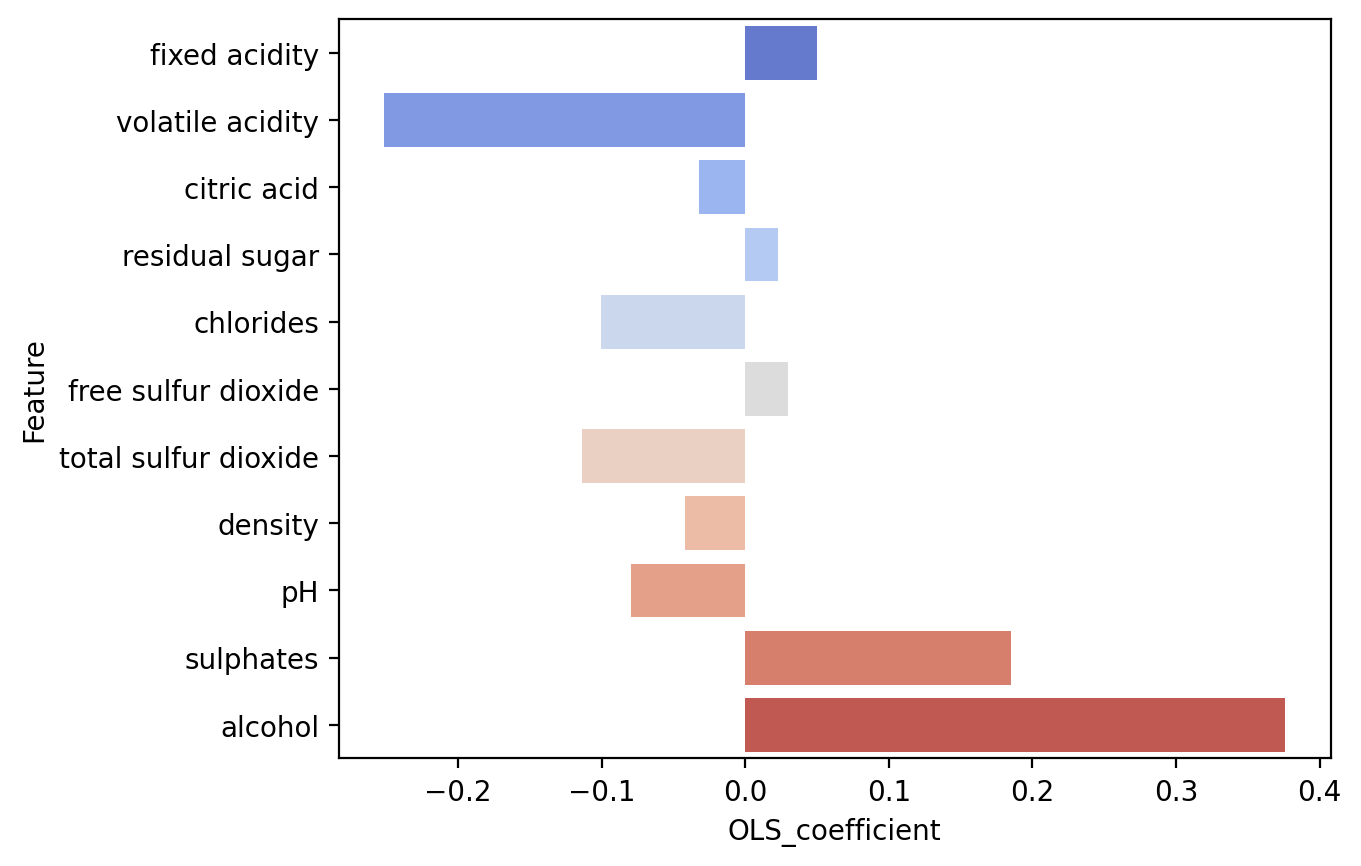

In [27]:
df_coefs = pd.DataFrame({'OLS_coefficient': model.params,
                        'Feature': features})
sns.barplot(data = df_coefs, y = 'Feature', x = 'OLS_coefficient', palette='coolwarm');

In [26]:
model.rsquared

0.3742422720434553

### The `fit_regularized` function

`fit_regularized` can be used to fit a **regularized model**.

- By default, this includes both $L_1$ and $L_2$ penalties.  
- Must set $\lambda$ (or `alpha`) parameter manually.
   - Typically we'd want to use cross-validation!
- Can also determine `L1_wt`: how much to weigh `L1` vs. `L2`.
   - If `L1_wt == 1`, then we're using Lasso.  
   - If `L1_wt == 0`, then we're using Ridge.

### Using `fit_regularized`

- To start, let's use a relatively small `alpha` value (`alpha = .05`).  
- We'll also set `L1_wt = 1`, which ensures we're fitting Lasso.

In [28]:
# First, create an OLS model
model = sm.OLS(y_scaled, X_scaled)

# Then, the model with L1 regularization (Lasso) with a specific alpha
lasso_result = model.fit_regularized(method='elastic_net', 
                                     L1_wt=1, ### Ensures we're fitting Lasso - fit_regularized fits elastic net, up to you to specify L1_wt
                                     alpha=.05) ## lambda parameter - you should use cross-validation to find the best value

## bigger alpha restrics the coefficients more

In [30]:
### Looking at our parameters -- sparse!
lasso_result.params

array([ 0.01533249, -0.24418419,  0.        ,  0.        , -0.01807468,
        0.        , -0.04651718,  0.        ,  0.        ,  0.11138848,
        0.36279957])

#### Inspecting coefficients

- Now, we see that some coefficients have been set to `0`. 
- The other features "survived" the regularization.

<Axes: xlabel='Lasso_coef', ylabel='Feature'>

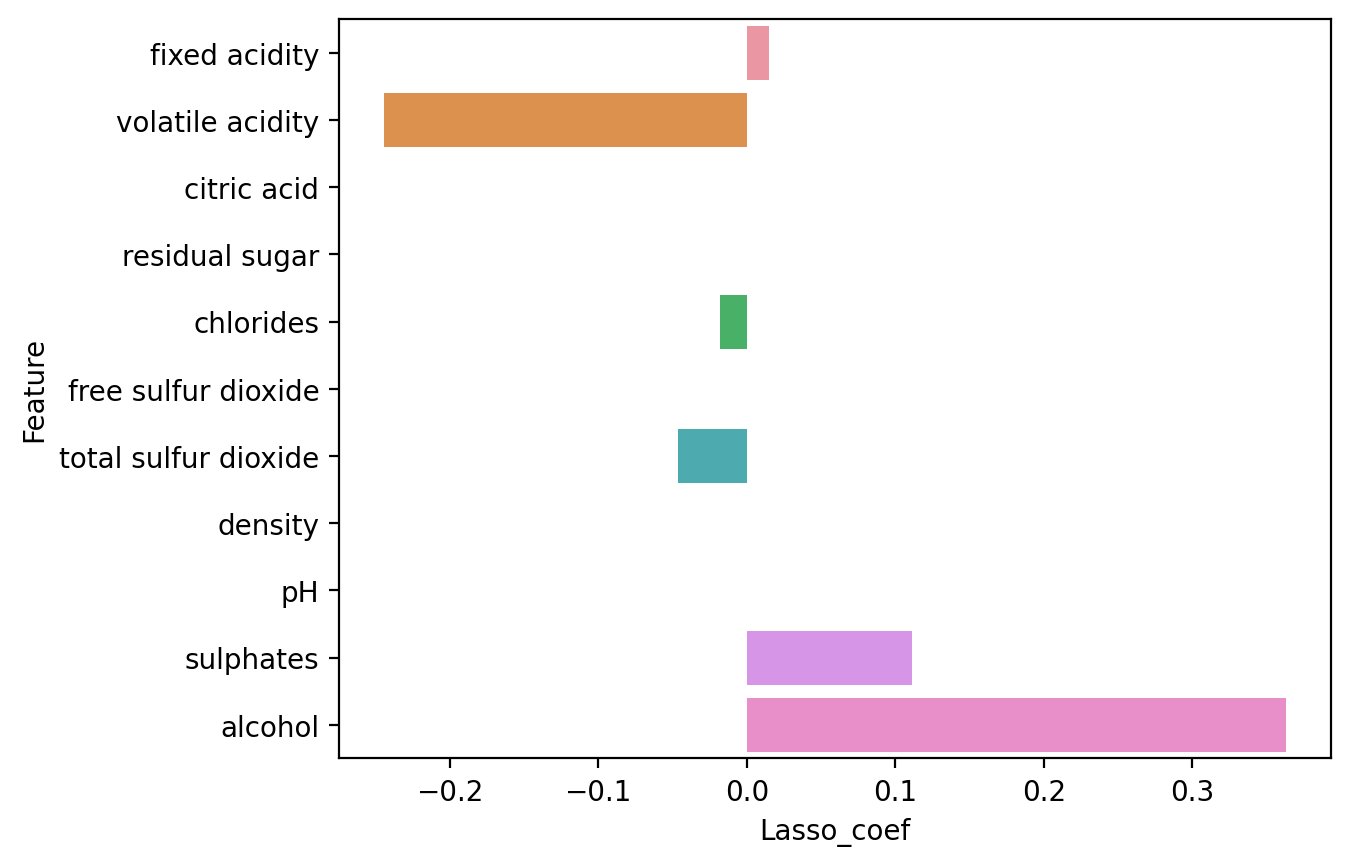

In [13]:
### Add to dataframe and visualize
df_coefs['Lasso_coef'] = lasso_result.params
sns.barplot(data = df_coefs, y = 'Feature', x = 'Lasso_coef')

#### Comparing to OLS

(-0.4, 0.4)

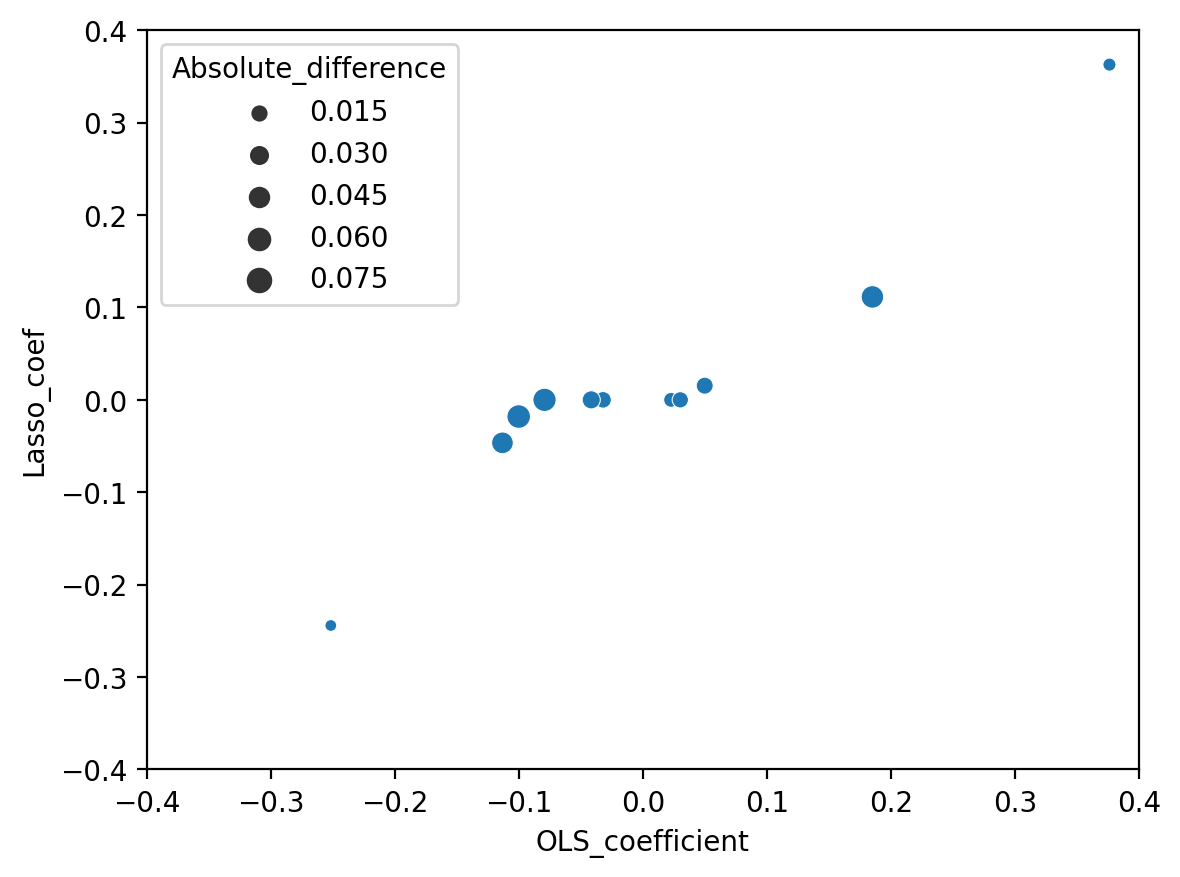

In [14]:
df_coefs['Absolute_difference'] = abs(df_coefs['OLS_coefficient'] - df_coefs['Lasso_coef'])
### Plot
sns.scatterplot(data = df_coefs, 
                x = "OLS_coefficient", 
                y = "Lasso_coef", 
               size = "Absolute_difference")
plt.xlim(-.4, .4)
plt.ylim(-.4, .4)

- Coefs in ols that are small get shrunk to zero by lasso.
- there is a linear ish relationship otherwise, which meakes sense.
- overall, sigmoid shape

#### Check-in: what about `L1_wt = 0`?

What kind of regularization will we be using if we set `L1_wt = 0`? Try running the same model with the same `alpha = .05`, but `L1_wt = 0`. What do you notice?

In [34]:
model = sm.OLS(y_scaled, X_scaled)

ridge_results = model.fit_regularized(method='elastic_net', L1_wt=0, alpha=.05)

In [35]:
ridge_results.params

array([ 0.06292241, -0.2358005 , -0.00774225,  0.02926152, -0.09844126,
        0.02470425, -0.10963658, -0.0679276 , -0.05867537,  0.18003208,
        0.34393988])

#### Use `L1_wt = 0` for ridge

In [36]:
# First, create an OLS model
model = sm.OLS(y_scaled, X_scaled)
ridge_result = model.fit_regularized(method='elastic_net', 
                                     L1_wt=0, ### Ensures we're fitting Ridge
                                     alpha=.05)

In [37]:
### Looking at our parameters
ridge_result.params

array([ 0.06292241, -0.2358005 , -0.00774225,  0.02926152, -0.09844126,
        0.02470425, -0.10963658, -0.0679276 , -0.05867537,  0.18003208,
        0.34393988])

#### Comparing to OLS

(-0.4, 0.4)

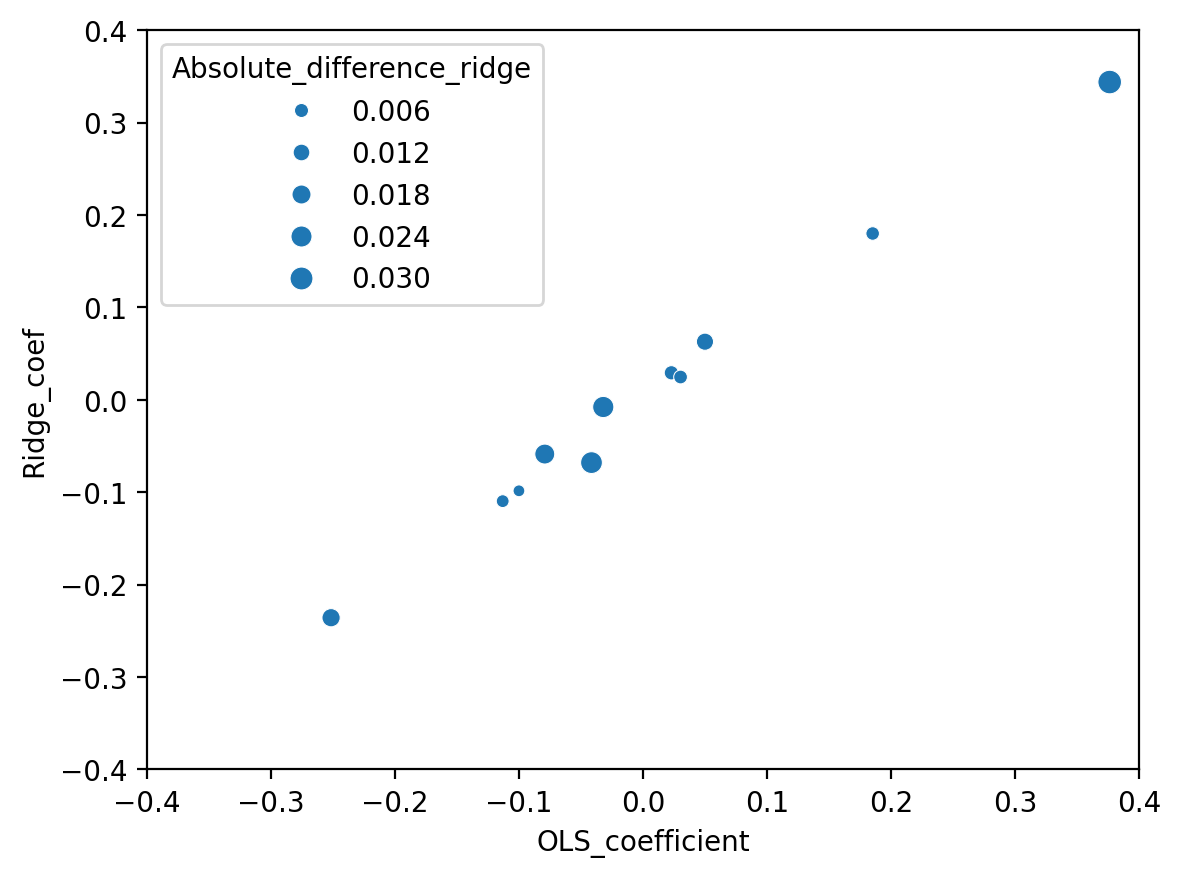

In [38]:
df_coefs['Ridge_coef'] = ridge_result.params
df_coefs['Absolute_difference_ridge'] = abs(df_coefs['OLS_coefficient'] - df_coefs['Ridge_coef'])
### Plot
sns.scatterplot(data = df_coefs, 
                x = "OLS_coefficient", 
                y = "Ridge_coef", 
               size = "Absolute_difference_ridge")
plt.xlim(-.4, .4)
plt.ylim(-.4, .4)

- no flattening in the middle now, just linear
- no coefs go to zero

### Comparing model fits

- Now, we want to compare the *fit* of each approach.  
- Ideally, we'd do this using **cross-validation**.  
  - Regularization is useful for preventing overfitting, so we want to see whether it improves upon standard OLS on a test set.

#### Step 1: Train/test split

Let's do a simple **train-test split**. 

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,
                                                    test_size=0.25, random_state=42)

#### Step 2: Fit our models on the training set

For now, we set `alpha = .05`. Typically, we'd also want to **tune** this parameter.

In [41]:
# Fit OLS
ols_model = sm.OLS(y_train, X_train).fit()

In [42]:
# Fit Lasso
lasso_model = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', 
                                                       L1_wt=1, alpha=0.01)

In [43]:
# Fit Ridge
ridge_model = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', 
                                                       L1_wt=0, alpha=0.01)

#### Step 3: Predict on test set

In [44]:
ols_pred = ols_model.predict(X_test)
lasso_pred = lasso_model.predict(X_test)
ridge_pred = ridge_model.predict(X_test)

#### Step 4: Evaluate on test set

- For this `alpha` value, Lasso > Ridge > OLS.
- This won't always be true! 

In [45]:
from sklearn.metrics import r2_score

# Calculate R^2 results
ols_r2 = r2_score(y_test, ols_pred)
lasso_r2 = r2_score(y_test, lasso_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

# Print the results
print("OLS R2:", ols_r2)
print("Lasso R2:", lasso_r2)
print("Ridge R2:", ridge_r2)

OLS R2: 0.3488020816227607
Lasso R2: 0.3537390580987302
Ridge R2: 0.35059266267764866


## Regularization in Python (`sklearn`)

In `sklearn`, the `linear_model` library contains classes for:

- `Ridge`: ridge regression.  
- `Lasso`: lasso regression.

Additionally, there are methods to fit an optimal $\lambda$ (or `alpha`) parameter:

- `RidgeCV`: uses cross-validation to fit an `alpha` parameter.  
- `LassoCV`: uses cross-validation to fit an `alpha` parameter.

### `Ridge` regression in Python

In [46]:
### Set up train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,
                                                    test_size=0.25, random_state=42)

In [47]:
### Import Ridge models
from sklearn.linear_model import Ridge, RidgeCV

#### Step 1: Fit optimal alpha

In [48]:
### Test out a range of alpha values
ridge_cv = RidgeCV(alphas=np.linspace(.1, 20, 100))
### Fit using training set
ridge_cv.fit(X_train, y_train)
print("Best alpha:", ridge_cv.alpha_)

Best alpha: 20.0


#### Step 2: Now fit using that optimal alpha

In [49]:
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train, y_train)

Ridge(alpha=20.0)

#### Step 3: Evaluate on training set

In [50]:
from sklearn.metrics import mean_squared_error

y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5702829600273577


### `Lasso` regression in Python

In [51]:
### Import Lasso models
from sklearn.linear_model import Lasso, LassoCV

#### Step 1: Fit optimal alpha

In [54]:
### Test out a range of alpha values
lasso_cv = LassoCV(alphas=np.linspace(.1, 20, 100))
### Fit using training set
lasso_cv.fit(X_train, y_train.ravel())
print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.1


#### Step 2: Now fit using that optimal alpha

In [55]:
lasso_model = Lasso(alpha=lasso_cv.alpha_)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1)

#### Step 3: Evaluate on training set

In [56]:
from sklearn.metrics import mean_squared_error

y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5814371744748892


### Compare to `LinearRegression`

In [57]:
### Import Lasso models
from sklearn.linear_model import LinearRegression

In [58]:
### Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

### Prediction
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.5736189978905449


## Regularization: general considerations

- **Powerful and widely used technique**:  
   - A version of regularization is actually used in training neural networks.  
- **Multiple types**:
   - Lasso: uses $L_1$ penalty, produces *sparse* models.  
   - Ridge: uses $L_2$ penalty, shrinks coefficients but not to zero.
   - Elastic net: combines Lasso and Ridge.
- **Requires tuning $\lambda$**:
   - $\lambda$ controls *strictness* of penalty.  
   - Typically, should be tuned using cross-validation.
- **Context-dependent**:
   - Sometimes, standard OLS will be the best approach!
   - Sometimes, ridge, lasso, or elastic net will be more effective.